# Задача 6. Компьютерное зрение: задача сегментации

**Автор**: Степырев Даниил Федорович

**Группа**: 22.М05

## Задание

Выполненные пункты:
- [✔️] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику jaccard index. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для jaccard index, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.

- [✔️] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.

- [✔️] Попробовать улучшить качество изменяя архитектуру.

## Датасет

В задаче используется датасет, указанный в условии. Доступен по ссылке: https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view. В датасете есть набор изображений людей и набор масок.

## Подключение библиотек

Подключим используемые библиотеки:

In [1]:
import random

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Зафиксируем сиды для воспроизведения результатов:

In [2]:
def set_seeds(initializer = 47):
    random.seed(initializer)
    torch.manual_seed(initializer)
    
set_seeds()

# Подготовка данных


Подключим Google Drive к Google Colab:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Распакуем архив с датасетом, который находится в корне Google Drive:

In [4]:
!unzip gdrive/My\ Drive/dataset.zip &> /dev/null

## Train/Test split

Считаем список путей изображений в папке **dataset/images/**:

In [5]:
from glob import glob

IMAGES_FOLDER_PATH = "./dataset/images"

imgs_list = glob(f"{IMAGES_FOLDER_PATH}/*")
print(f"Images list length: {len(imgs_list)}")

Images list length: 2000


Заведём класс для хранения изображений и их масок.

Название изображения маски похоже на название исходного изображения. Достаточно заменить папку с **images** на **masks**, а также сменить расширение файла с **.jpg** на **.png**. Тогда для получения изображения и его маски необходимо знать лишь путь до изображения.

In [6]:
from torch.utils.data import Dataset
import numpy as np
import torch
import torchvision
from torchvision import io
import cv2

class SelfieDataset(Dataset):
    def __init__(self, imgs_list, transform = lambda id: id):
        self.imgs = imgs_list
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def get_mask_path(self, img_path):
        mask_path = img_path.split("/")
        mask_path[-2] = mask_path[-2].replace("images", "masks")
        mask_path[-1] = mask_path[-1][:-4] + ".png"
        mask_path = "/".join(mask_path)
        return mask_path

    def resize_image(self, img):
        return torchvision.transforms.Resize((256, 256))(img)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = self.resize_image(io.read_image(img_path))
        img = self.transform(img / 255)
        
        mask_path = self.get_mask_path(img_path)
        mask = self.resize_image(io.read_image(mask_path))
        mask = self.transform(mask / 255)

        return img, mask

Заведём test и train выборки:

In [7]:
train_dataset = SelfieDataset(imgs_list[:-300])
test_dataset = SelfieDataset(imgs_list[-300:])

print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 1700
Test dataset length: 300


Заведём функцию для отображения изображения из SelfieDataset:

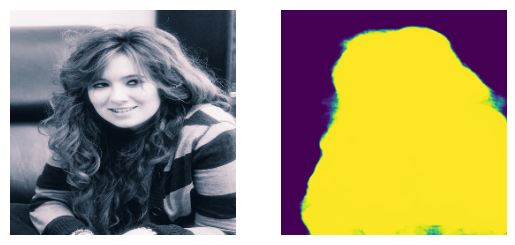

In [8]:
from torchvision.transforms import functional

def show_selfie(image, mask, is_mask_shown=True):
    _, (ax_l, ax_r) = plt.subplots(ncols=2)
    ax_l.imshow(functional.to_pil_image(image))
    ax_l.axis("off")
    ax_r.imshow(functional.to_pil_image(mask))
    ax_r.axis("off")

image, mask = train_dataset[0]
show_selfie(image, mask)

## Jaccard Index метрика

Добавим функцию вычисления Jaccard Index метрики из библиотеки torchmetrics:

In [9]:
!pip install torchmetrics  &> /dev/null
import torchmetrics

jaccard = torchmetrics.JaccardIndex(task="binary")

def calculate_jaccard_metric(y_pred, y_true):
    return jaccard(y_pred.cpu(), y_true.cpu() > jaccard.threshold)

## Реализация UNET

Реализуем UNET аналогично тому, как делали на практическом занятии.

Реализация Encoder:

In [10]:
from torch import nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections
    
    

Реализация Decoder:

In [11]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

Реализация UNET:

In [12]:
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

## Переобучение на одном батче

Выполним переобучение на одном батче. Возьмём четыре картинки.

In [13]:
train_subset = torch.utils.data.Subset(train_dataset, range(4))
train_dataset_loader = torch.utils.data.DataLoader(train_subset, batch_size=4)

test_subset = torch.utils.data.Subset(test_dataset, range(4))
test_dataset_loader = torch.utils.data.DataLoader(test_subset, batch_size=4)

Реализуем функции обучения модели. Вычисленные значения loss, Jaccard Index Metric будем сохранять в словарь, чтобы по итогу обучения вернуть датафрейм. Датафрейм будет полезен для построения графиков.

In [14]:
from tqdm import tqdm

TRAIN_DATASET_NAME = "Train dataset"
TEST_DATASET_NAME = "Test dataset"
LOSS_PARAMETER = "Loss"
JACCARD_INDEX_PARAMETER = "Jaccard Index"
device = "cuda"

results_columns = ["Epoch number", "Dataset", "Parameter", "Result"]

net = UNET(3, 16, 1)
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

def train(net, optimizer, loader):
    net.train()

    running_loss = 0.0
    running_metric = 0.0
    for x, y in tqdm(loader):
        x = x.cuda()
        y = y.cuda()
        
        optimizer.zero_grad()
        pred = net(x)
        
        loss = criterion(pred, y)
        metric = calculate_jaccard_metric(pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_metric += metric.item()

    return running_loss / len(loader), running_metric / len(loader)


def predict(net, loader):
    net.eval()

    running_loss = 0.0
    running_metric = 0.0
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.cuda()
            y = y.cuda()
            pred = net(x)
            running_loss += criterion(pred, y).item()
            running_metric += calculate_jaccard_metric(pred, y).item()

    return running_loss / len(loader), running_metric / len(loader)


def train_model(net, optimizer, train_dataset_loader, test_dataset_loader, epoch_number):
    results = []
    for epoch in range(epoch_number):
        loss_train, metric_train = train(net, optimizer, train_dataset_loader)
        loss_test, metric_test = predict(net, test_dataset_loader)
        results += [
            (epoch, TRAIN_DATASET_NAME, LOSS_PARAMETER, loss_train),
            (epoch, TRAIN_DATASET_NAME, JACCARD_INDEX_PARAMETER, metric_train),
            (epoch, TEST_DATASET_NAME, LOSS_PARAMETER, loss_test),
            (epoch, TEST_DATASET_NAME, JACCARD_INDEX_PARAMETER, metric_test),
        ]

    return pd.DataFrame(results, columns=results_columns)

Выполним переобучение на одном батче:

In [15]:
train_model(net, optimizer, train_dataset_loader, test_dataset_loader, 50).to_csv("results-batch.csv")

100%|██████████| 1/1 [00:00<00:00,  7.51it/s]


Заведём функцию отображения результатов:

In [16]:
def show_result_plot(results, plot_title = ""):
    fig, (ax_1, ax_2) = plt.subplots(nrows=2, sharex=True, figsize=(15, 5))

    sns.lineplot(results[results["Parameter"] == LOSS_PARAMETER], x="Epoch number", y="Result", hue="Dataset",ax=ax_1)
    ax_1.set_title(LOSS_PARAMETER)

    sns.lineplot(results[results["Parameter"] == JACCARD_INDEX_PARAMETER], x="Epoch number", y="Result", hue="Dataset", ax=ax_2)
    ax_2.set_title(JACCARD_INDEX_PARAMETER)

    fig.suptitle(plot_title)
    fig.tight_layout()

Построим график обучения на одном батче:

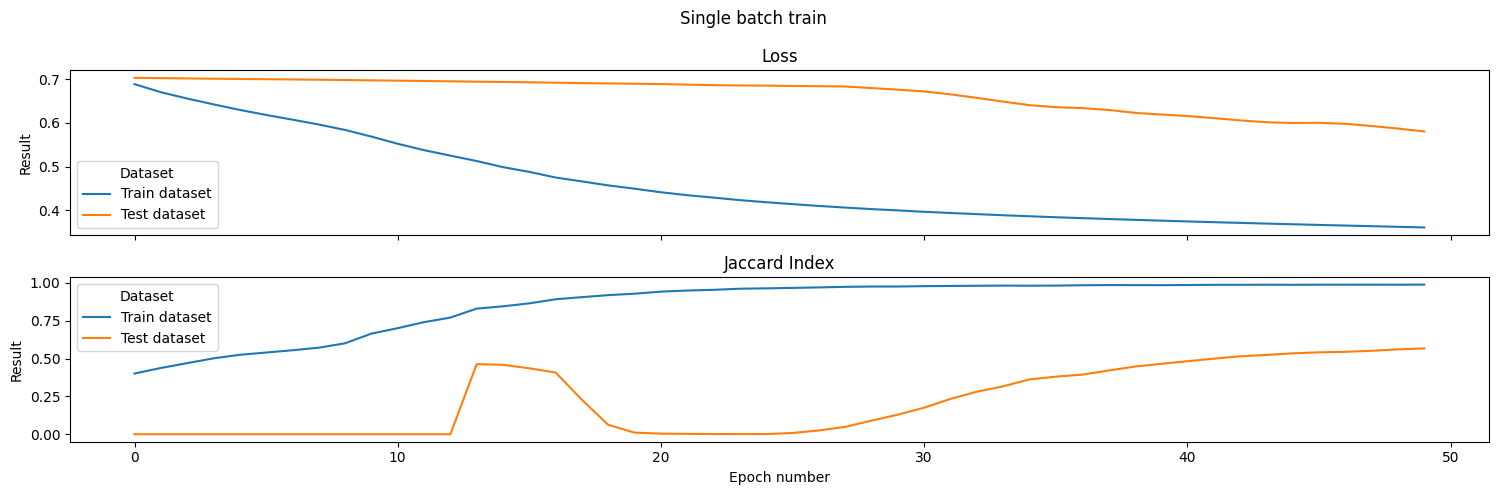

In [17]:
results = pd.read_csv("results-batch.csv")
show_result_plot(results, "Single batch train")

In [18]:
display(results)

,Unnamed: 0,Epoch number,Dataset,Parameter,Result
0,0,0,Train dataset,Loss,0.689161
1,1,0,Train dataset,Jaccard Index,0.401114
2,2,0,Test dataset,Loss,0.703619
3,3,0,Test dataset,Jaccard Index,0.000000
4,4,1,Train dataset,Loss,0.670593
...,...,...,...,...,...
195,195,48,Test dataset,Jaccard Index,0.560807
196,196,49,Train dataset,Loss,0.360389
197,197,49,Train dataset,Jaccard Index,0.988790
198,198,49,Test dataset,Loss,0.580595


Train dataset result
Test dataset result


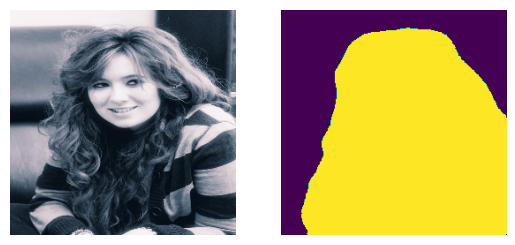

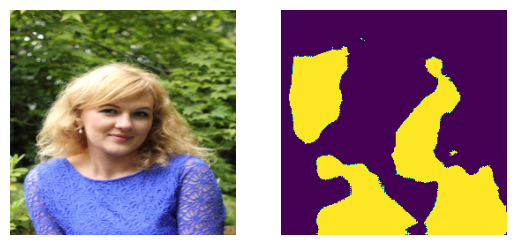

In [19]:
net.eval()

print("Train dataset result")
train_img, mask = train_dataset[0]
train_mask = net(train_img.cuda().unsqueeze(0))[0].cpu()
show_selfie(train_img, nn.functional.sigmoid(train_mask > 0))

print("Test dataset result")
test_img, mask = test_dataset[0]
test_mask = net(test_img.cuda().unsqueeze(0))[0].cpu()
show_selfie(test_img, nn.functional.sigmoid(test_mask > 0))

Видим, что результат обучающей выборки лучше результата тестовой. При возрастании числа шагов обучения снижается Loss и возрастает Jaccard Index.

# Обучение на всём Train

Выполним обучение на всей Train выборке. В качестве размера батча возьмём число 16.

In [20]:
batch_size = 16
epoch_number = 15 # Google Colab limits accounts for a big computations
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Обучим модель на всей выборке. Возьмём для теста 15 эпох. Результаты сохраним в results.csv.

In [21]:
from torch.utils.data.datapipes.datapipe import UNTRACABLE_DATAFRAME_PIPES
net = UNET(3, 16, 1)
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

train_model(net, optimizer, train_loader, test_loader, epoch_number).to_csv("results.csv")

100%|██████████| 19/19 [00:04<00:00,  4.26it/s]


Построим график результатов обучения модели на всей выборке:

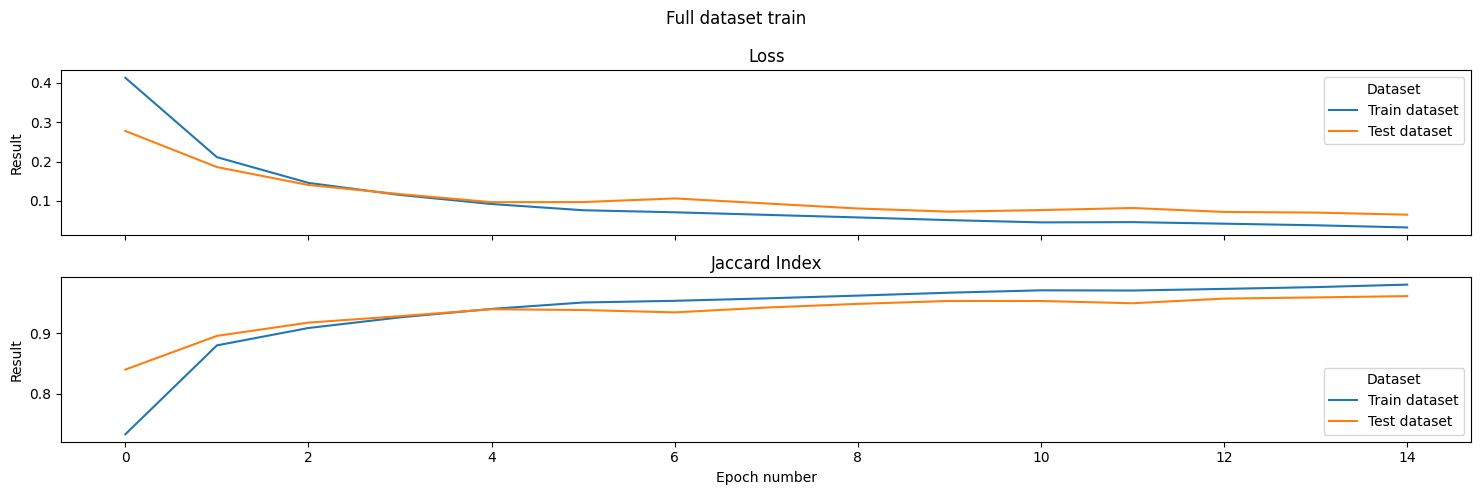

In [22]:
results = pd.read_csv("results.csv")
show_result_plot(results, "Full dataset train")

Из графика видим, что с увеличением числа шагов уменьшается Loss и увеличчивается Jaccard Index.

Выведем полученные результаты как таблицу:

In [23]:
display(results)

,Unnamed: 0,Epoch number,Dataset,Parameter,Result
0,0,0,Train dataset,Loss,0.413166
1,1,0,Train dataset,Jaccard Index,0.732785
2,2,0,Test dataset,Loss,0.277782
3,3,0,Test dataset,Jaccard Index,0.839998
4,4,1,Train dataset,Loss,0.211105
5,5,1,Train dataset,Jaccard Index,0.880088
6,6,1,Test dataset,Loss,0.185908
7,7,1,Test dataset,Jaccard Index,0.895853
8,8,2,Train dataset,Loss,0.145633
9,9,2,Train dataset,Jaccard Index,0.908924


Реализуем функцию отбора самых плохих предсказаний:

In [24]:
def show_worst_predictions(net, number):
    predictions = []
    for i, data in tqdm(enumerate(test_loader, 0)):
        x = data[0]
        y = data[1]
        pred = net(x.cuda())
        metric = calculate_jaccard_metric(pred, y).item()
        predictions.append((metric, i))

    worst_predictions = sorted(predictions)[:number]
    for _, idx in worst_predictions:
        image, mask = test_dataset[idx]
        pred = net(image.cuda().unsqueeze(0))
        show_selfie(image, nn.functional.sigmoid(pred[0].cpu() > 0))

Найдем 5 худших результатов:

19it [00:04,  3.97it/s]


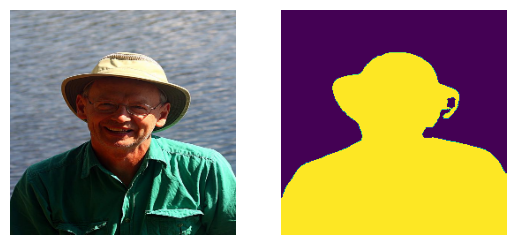

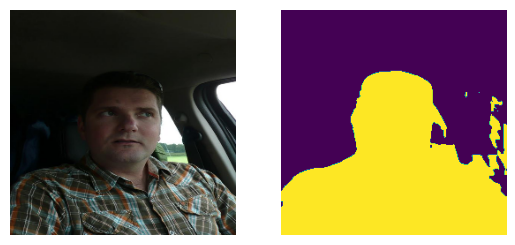

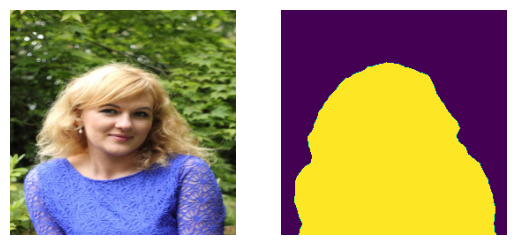

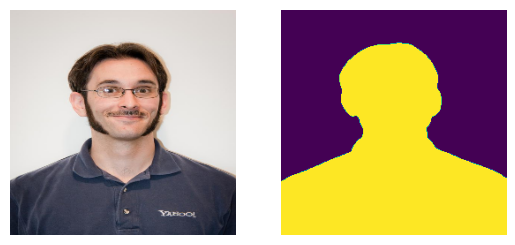

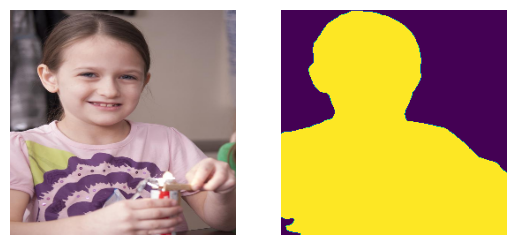

In [25]:
show_worst_predictions(net, 5)

Видим, что хоть результаты и не очень, удалось выделить контур лица человека.

# Аугментация

Попробуем улучшить качество предсказаний с помощью аугментации. Модифицируем существующие данные для увеличения выборки.

Применим отражение по горизонтали (horizontal flip) и изменение цвета изображения (color jitter):

In [26]:
import copy
from torchvision import transforms

transformations = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=.5, hue=.3)
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = transformations

train_dataset_extended = torch.utils.data.ConcatDataset(
    [train_dataset_augmented, copy.copy(train_dataset)]
)

train_loader_extended = torch.utils.data.DataLoader(train_dataset_extended, batch_size=batch_size)

(-0.5, 255.5, 255.5, -0.5)

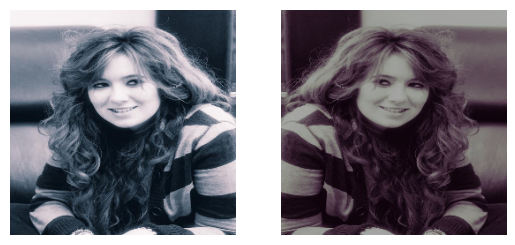

In [27]:
img_train, mask = train_dataset[0]
img_aug, mask = train_dataset_augmented[0]

_, (ax_l, ax_r) = plt.subplots(ncols=2)
ax_l.imshow(functional.to_pil_image(img_train))
ax_l.axis("off")
ax_r.imshow(functional.to_pil_image(img_aug))
ax_r.axis("off")

Дообучим прошлую модель на расширенных данных:

In [28]:
train_model(net, optimizer, train_loader_extended, test_loader, epoch_number).to_csv("results-augmented.csv")

100%|██████████| 19/19 [00:03<00:00,  4.88it/s]


Сразу можно заметить, что время обучения возросло в три раза. Построим график с результатами:

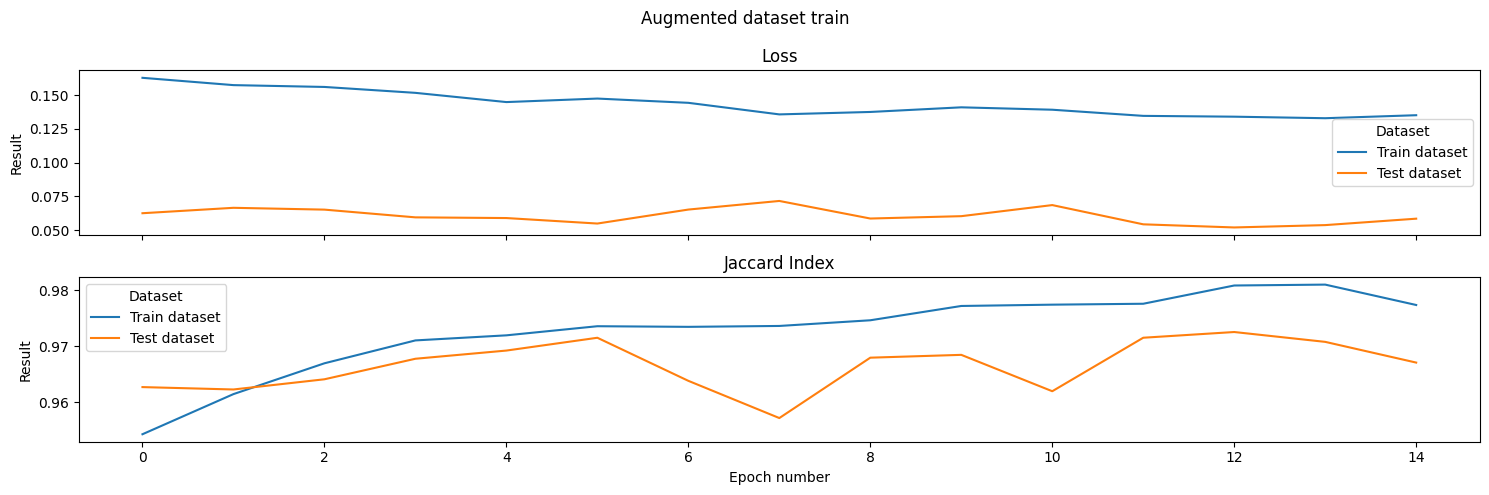

In [29]:
results = pd.read_csv("results-augmented.csv")
show_result_plot(results, "Augmented dataset train")

Видим на графике, что Loss для тестовой выборки уменьшился, а Jaccard Index увеличился.

Выведем таблицу значений:

In [30]:
display(results)

,Unnamed: 0,Epoch number,Dataset,Parameter,Result
0,0,0,Train dataset,Loss,0.162733
1,1,0,Train dataset,Jaccard Index,0.954263
2,2,0,Test dataset,Loss,0.062488
3,3,0,Test dataset,Jaccard Index,0.962696
4,4,1,Train dataset,Loss,0.157326
5,5,1,Train dataset,Jaccard Index,0.961442
6,6,1,Test dataset,Loss,0.066493
7,7,1,Test dataset,Jaccard Index,0.962269
8,8,2,Train dataset,Loss,0.155973
9,9,2,Train dataset,Jaccard Index,0.966953


Посмотрим на 5 худших предсказаний:

19it [00:04,  4.75it/s]


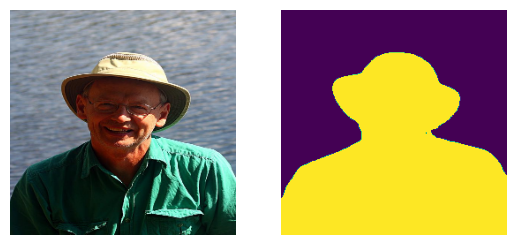

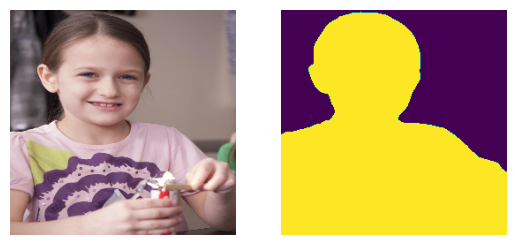

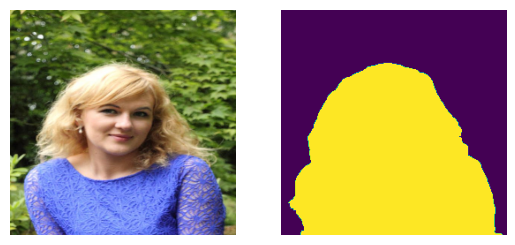

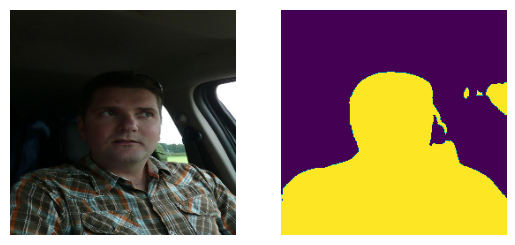

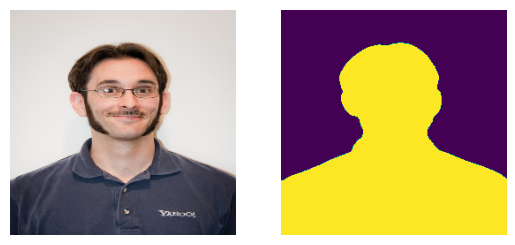

In [31]:
show_worst_predictions(net, 5)

Также можно заметить, что на худших предсказаниях при аугментированном датасете можно хорошо раглядеть контур человека. Результат визуально лучше, чем до аугментации.

# Гиперпараметры

Попробуем улучшить качество предсказаний с помощью подбора гиперпараметров. Попробуем разные значения n_down:

In [32]:
def train_and_save_to_csv(n_down, train_loader, test_loader):
    net = UNET(3, 16, 1, n_down=n_down).cuda()
    optimizer = torch.optim.Adam(net.parameters())

    train_model(net, optimizer, train_loader, test_loader, epoch_number).to_csv(f"results-hyperparam-{n_down}.csv")

n_down_parameters = [2, 4, 8]
for n_down in n_down_parameters:
    print(f"Training net with {n_down} n_down")
    train_and_save_to_csv(n_down, train_loader, test_loader)

Training net with 2 n_down


100%|██████████| 19/19 [00:03<00:00,  5.29it/s]


Training net with 4 n_down


100%|██████████| 19/19 [00:04<00:00,  4.34it/s]


Training net with 8 n_down


100%|██████████| 19/19 [00:04<00:00,  3.97it/s]


Посмотрим график результата для n_down = 2:

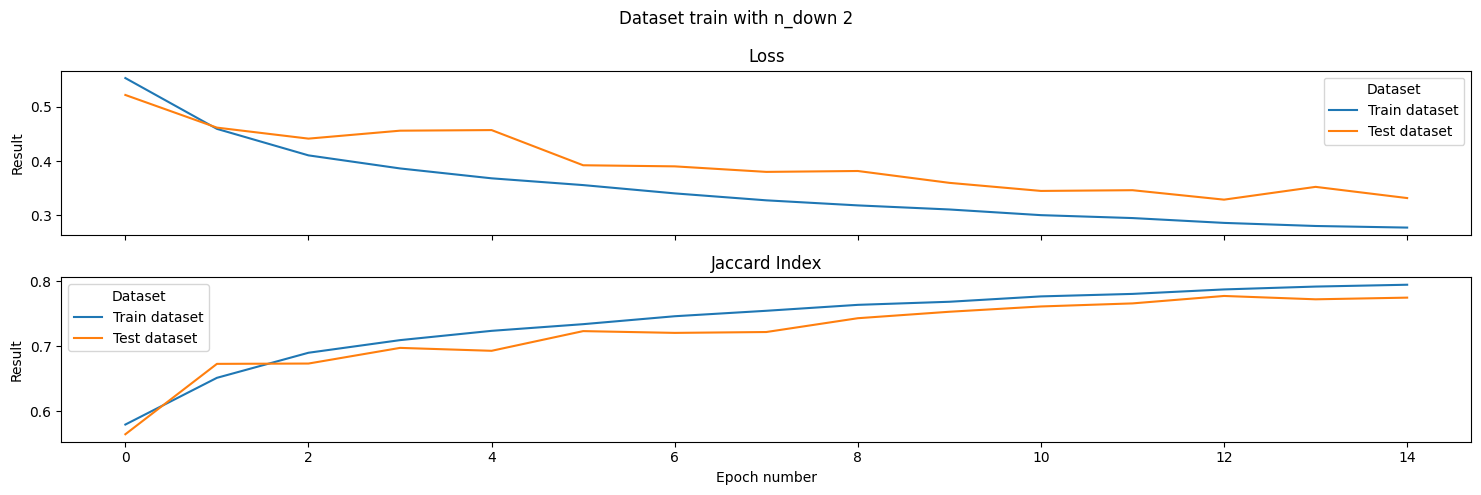

In [33]:
results = pd.read_csv("results-hyperparam-2.csv")
show_result_plot(results, "Dataset train with n_down 2")

In [34]:
display(results)

,Unnamed: 0,Epoch number,Dataset,Parameter,Result
0,0,0,Train dataset,Loss,0.553259
1,1,0,Train dataset,Jaccard Index,0.579161
2,2,0,Test dataset,Loss,0.522036
3,3,0,Test dataset,Jaccard Index,0.564218
4,4,1,Train dataset,Loss,0.459412
5,5,1,Train dataset,Jaccard Index,0.651142
6,6,1,Test dataset,Loss,0.461715
7,7,1,Test dataset,Jaccard Index,0.672654
8,8,2,Train dataset,Loss,0.410434
9,9,2,Train dataset,Jaccard Index,0.689770


Посмотрим график результата для n_down = 4:

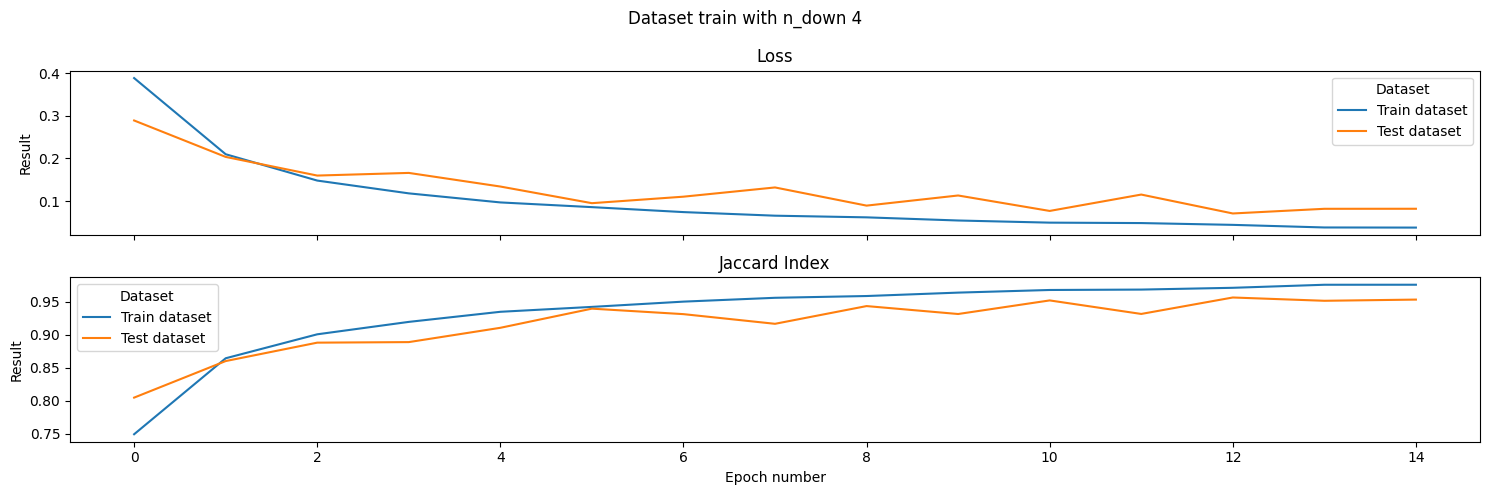

In [35]:
results = pd.read_csv("results-hyperparam-4.csv")
show_result_plot(results, "Dataset train with n_down 4")

In [36]:
display(results)

,Unnamed: 0,Epoch number,Dataset,Parameter,Result
0,0,0,Train dataset,Loss,0.388236
1,1,0,Train dataset,Jaccard Index,0.749236
2,2,0,Test dataset,Loss,0.288875
3,3,0,Test dataset,Jaccard Index,0.804799
4,4,1,Train dataset,Loss,0.209797
5,5,1,Train dataset,Jaccard Index,0.864485
6,6,1,Test dataset,Loss,0.203527
7,7,1,Test dataset,Jaccard Index,0.860250
8,8,2,Train dataset,Loss,0.148082
9,9,2,Train dataset,Jaccard Index,0.900843


Посмотрим график результата для n_down = 8:

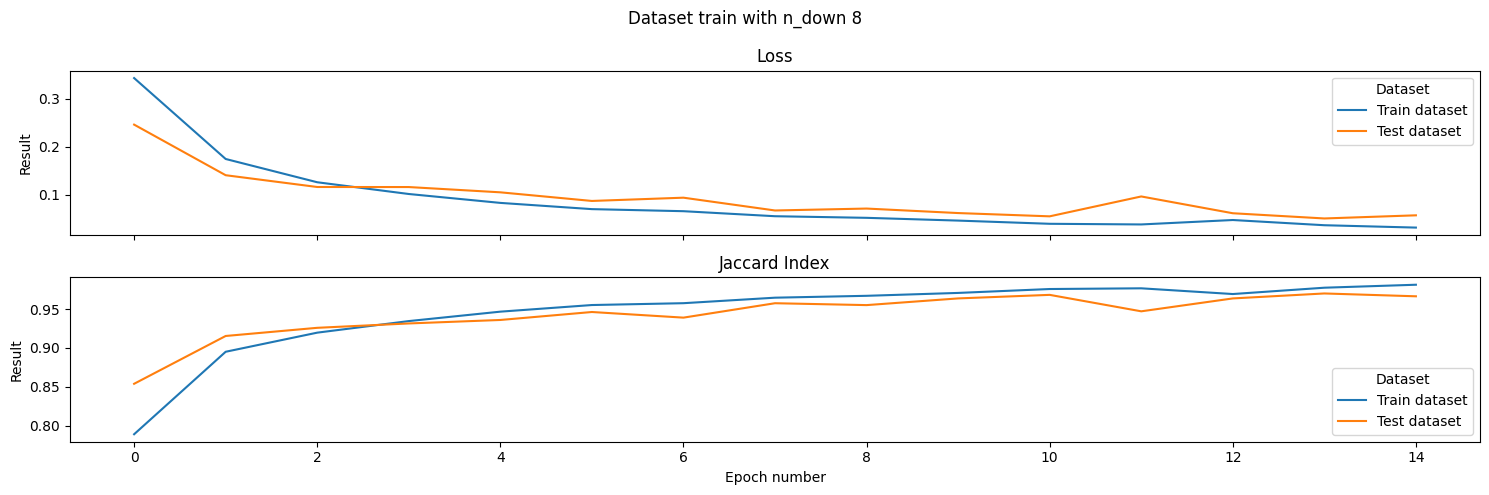

In [37]:
results = pd.read_csv("results-hyperparam-8.csv")
show_result_plot(results, "Dataset train with n_down 8")

In [38]:
display(results)

,Unnamed: 0,Epoch number,Dataset,Parameter,Result
0,0,0,Train dataset,Loss,0.343072
1,1,0,Train dataset,Jaccard Index,0.789129
2,2,0,Test dataset,Loss,0.246007
3,3,0,Test dataset,Jaccard Index,0.853986
4,4,1,Train dataset,Loss,0.174326
5,5,1,Train dataset,Jaccard Index,0.895145
6,6,1,Test dataset,Loss,0.140469
7,7,1,Test dataset,Jaccard Index,0.915433
8,8,2,Train dataset,Loss,0.125801
9,9,2,Train dataset,Jaccard Index,0.919702


С увеличением n_down увеличивается время обучения. Модель с параметром n_down оказалось самой быстробучаемой. Самая медленная скорость обучения у модели с n_down = 8.

Если смотреть на значения Loss, то лучше всего отработала модель с параметром n_down = 8.

Если смотреть на значения Jaccard Index, то лучше всего отработала модель с параметром n_down = 8.



Посмотрим на худшие предсказания последней модели:

19it [00:04,  3.91it/s]


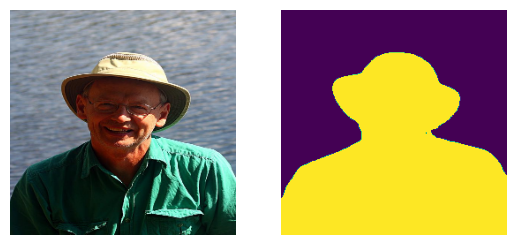

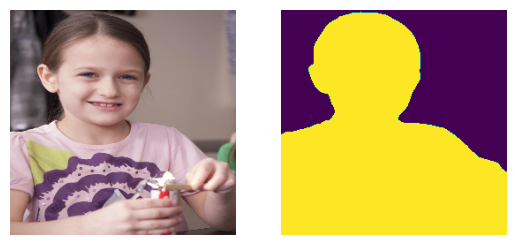

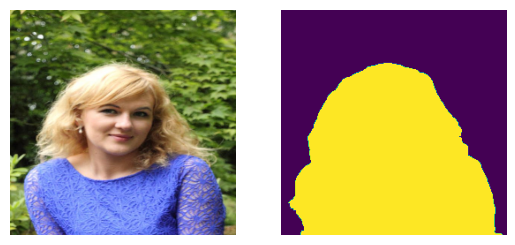

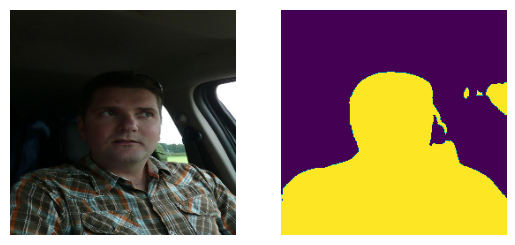

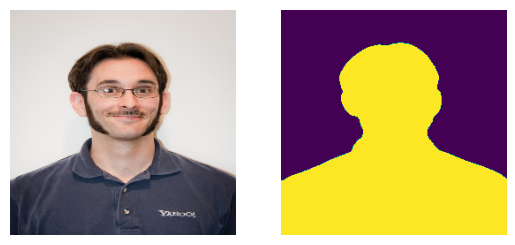

In [39]:
show_worst_predictions(net, 5)

Видим, что удалось выделить контур фигуры человека.

# Test Time аугментации

Реализуем Test Time аугментацию, используя horizontal flip:

In [40]:
class SegmentationTTAWrapper(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net


    def horizontal_flip(self, image):
        # Use p = 1 to flip image.
        transformation = transforms.RandomHorizontalFlip(p=1)
        return transformation(image)
    

    def forward(self, image):
        flipped_image = self.horizontal_flip(image)
        concatenated_image = torch.cat([image, flipped_image])
        prediction = self.net(concatenated_image)

        result, augmented_result = prediction.chunk(2)
        flipped_augmented_result = self.horizontal_flip(augmented_result)

        return torch.mean(torch.stack([result, flipped_augmented_result]), dim=0)

Обучим TTA модель:

In [42]:
net = UNET(3, 16, 1).cuda()
tta_net = SegmentationTTAWrapper(net).cuda()

optimizer = torch.optim.Adam(tta_net.parameters())
train_model(tta_net, optimizer, train_loader, test_loader, epoch_number).to_csv(f"results-tta.csv")

100%|██████████| 19/19 [00:04<00:00,  4.10it/s]


Посмотрим график результата для TTA:

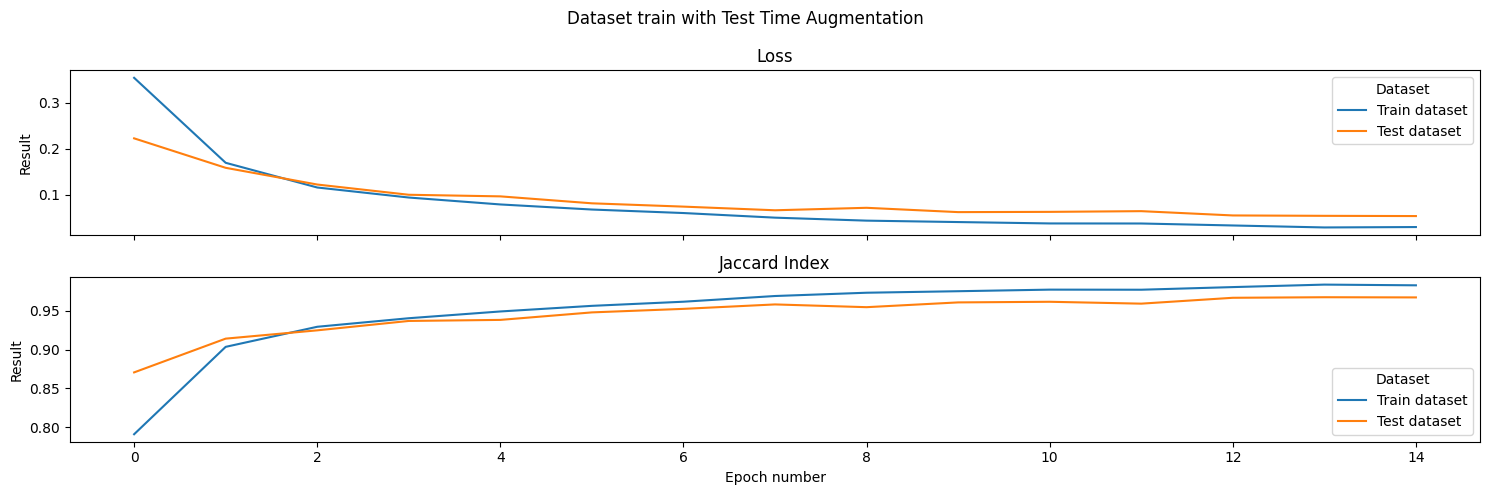

In [43]:
results = pd.read_csv("results-tta.csv")
show_result_plot(results, "Dataset train with Test Time Augmentation")

In [44]:
display(results)

,Unnamed: 0,Epoch number,Dataset,Parameter,Result
0,0,0,Train dataset,Loss,0.354610
1,1,0,Train dataset,Jaccard Index,0.790974
2,2,0,Test dataset,Loss,0.222737
3,3,0,Test dataset,Jaccard Index,0.870548
4,4,1,Train dataset,Loss,0.169482
5,5,1,Train dataset,Jaccard Index,0.903408
6,6,1,Test dataset,Loss,0.158551
7,7,1,Test dataset,Jaccard Index,0.913986
8,8,2,Train dataset,Loss,0.115671
9,9,2,Train dataset,Jaccard Index,0.929238


Из графика и результатов видим, что по сравнению с обычной UNET моделью значение Loss стало меньше, а Jaccard Index больше.

Было:
- Loss = 0.094;
- Jaccard Index = 0.945.

Стало:
- Loss = 0.053;
- Jaccard Index = 0.967.

# Изменение архитектуры

Попробуем улучшить качество, изменив архитектуру решения. Возьмём архитектуру, описанную из Pytorch-UNet: https://github.com/milesial/Pytorch-UNet.

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

  
class UNetNew(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNetNew, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [46]:
net = UNetNew(3, 1).cuda()
optimizer = torch.optim.Adam(net.parameters())

train_model(net, optimizer, train_loader, test_loader, epoch_number).to_csv("results-architecture.csv")

100%|██████████| 19/19 [00:07<00:00,  2.46it/s]


Построим график результатов обучения с новой архитектурой:

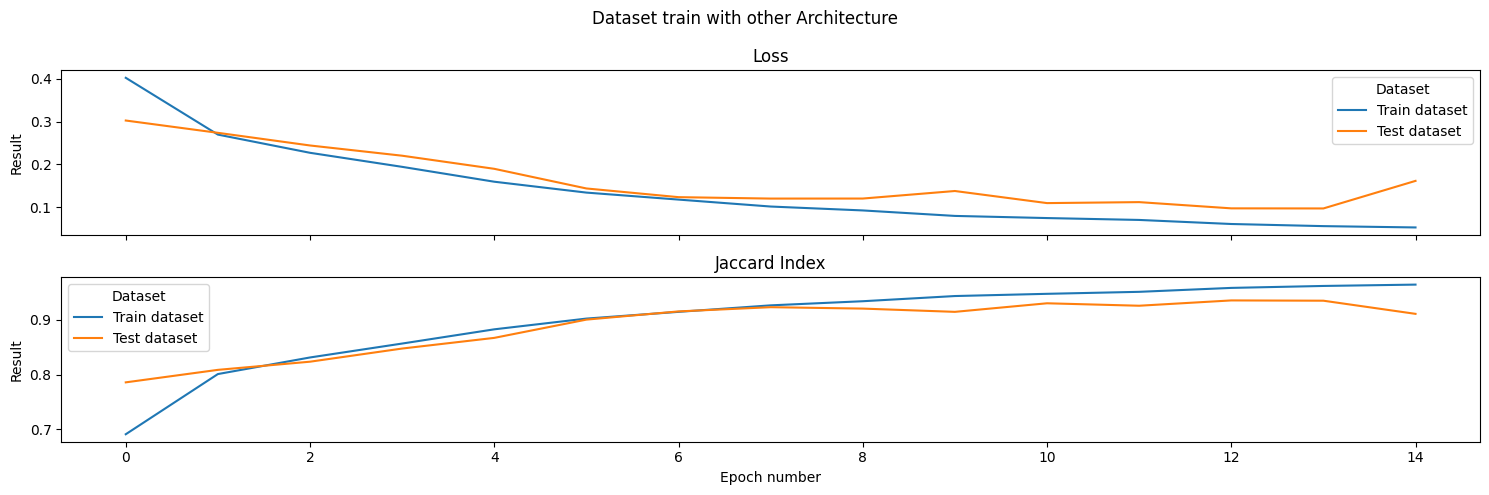

In [47]:
results = pd.read_csv("results-architecture.csv")
show_result_plot(results, "Dataset train with other Architecture")

In [48]:
display(results)

,Unnamed: 0,Epoch number,Dataset,Parameter,Result
0,0,0,Train dataset,Loss,0.402068
1,1,0,Train dataset,Jaccard Index,0.691269
2,2,0,Test dataset,Loss,0.302401
3,3,0,Test dataset,Jaccard Index,0.785974
4,4,1,Train dataset,Loss,0.269542
5,5,1,Train dataset,Jaccard Index,0.801119
6,6,1,Test dataset,Loss,0.273703
7,7,1,Test dataset,Jaccard Index,0.808789
8,8,2,Train dataset,Loss,0.227061
9,9,2,Train dataset,Jaccard Index,0.831405


Видим, что результаты немного хуже, чем при исходной архитектуре и TTA. Обучение проводилось с тем же числом шагов. На тестовой выборке получился лучший результат Loss = 0.075, Jaccard Index = 0.915. Скорость обучения медленнее исходной модели.

# Выводы

Таблица с результатами обучения:

| Метод обучения        | Параметр | Результат  |
| --------------------- | -------- | ---------  |
| Один батч             | Loss          | 0.580 |
|                       | Jaccard Index | 0.567 |
|  Train                | Loss          | 0.064 |
|                       |Jaccard Index  | 0.961 |
| Аугментация           | Loss          | 0.058 |
|                       |Jaccard Index  | 0.967 |
| Гиперпараметры        | Loss          | 0.067 |
|                       |Jaccard Index  | 0.964 |
| Test Time аугментация | Loss          | 0.040 |
|                       |Jaccard Index  | 0.975 |
| Другая архитектура    | Loss          | 0.075 |
|                       |Jaccard Index  | 0.915 |

- Переобучение на одном батче не дало идеального качества на тестовой выборке:
  + Лучшее значение Loss: 0.580;
  + Лучшее значение Jaccard Index: 0.567.
- Аугментация позволяет сильно улучшить качество предсказаний исходной модели.
  + Использование аугментации значительно увеличивает длительность обучения модели -- на тестовых данных длительность обучения возросло в три раза.
  + Лучшее значение Loss: 0.058;
  + Лучшее значение Jaccard Index: 0.967.
- Подбор гиперпараметров позволяят улучшить качество предсказаний исходной модели. На тестовых данных лучшим гиперпараметром оказался n_down = 8.
  + Подбор гиперпараметров увеличивает время обучения модели -- с n_down = 8 обучение выполняется в два раза дольше, чем с n_down = 2.
  + Лучшее значение Loss: 0.067.
  + Лучшее значение Jaccard Index: 0.964.
- Использование Test Time аугментации позволяет улучшить качество предсказаний исходной модели.
  + Использование Test Time аугментации увеличивает время обучения модели -- примерно на 5 секунд для каждого шага.
  + Лучшее значение Loss: 0.040.
  + Лучшее значение Jaccard Index: 0.975.
- Изменение архитектуры влияет на качество предсказаний.
  + В качестве примера была использована реализация из открытых источников;
  + Лучшее значение Loss: 0.075.
  + Лучшее значение Jaccard Index: 0.915.

